# Question 3

### PID Controller

The input being sent to the robot (from the PID Controller) will be the required torque on the motor.

References:
- https://modernrobotics.northwestern.edu/nu-gm-book-resource/11-4-motion-control-with-torque-or-force-inputs-part-1-of-3/
- PID control torque = kp * position_error + ki * integral_of_error + kd * derivative_of_error

In [13]:
class Controller:
    def __init__(self, kp, ki, kd):
        self.kp = kp # Proportional
        self.ki = ki # Integral
        self.kd = kd # Derivative
        self.totalError = 0
        self.prevError = 0
        self.verbose = False # For testing

    def output(self, currentTilt, setPoint, timeStep):
        
        error = setPoint - currentTilt
        self.totalError += error * timeStep
        dError = (error - self.prevError) / timeStep
        if self.verbose:
            print("totalError =", self.totalError, "dError =", dError)

        torque = (self.kp * error) + (self.ki * self.totalError) + (self.kd * dError)
        if self.verbose:
            print("torque =", torque)

        self.prevError = error
        return torque

In [14]:
# Testing
ctl = Controller(1.0, 0.1, 0.01)
ctl.verbose = True
print(ctl.output(0, 10, 0.1))

totalError = 1.0 dError = 100.0
torque = 11.1
11.1


In [15]:
# Also testing
ctl = Controller(50, 0.1, 5)
ctl.verbose = True
print(ctl.output(0, 10, 1))

totalError = 10 dError = 10.0
torque = 551.0
551.0


### Random Noise

Simulate a random noise (environmental error force vector `Fe`) with a magnitude between `0N` and `1000N` from a distance between 0 and `diste` meters on every 30th timestep of your simulation.

In [16]:
import numpy as np
def random_noise(diste, total_time_step, magnitude=1000, freq=30):
    """ Calculate noise
    """
    if total_time_step % freq == 0:
        magnitude = np.random.uniform(-magnitude, magnitude)
        distance = np.random.uniform(0, diste)
        return magnitude, distance
    return 0, 0


for t in range(10):
    print(random_noise(0.2, t, freq=5))

(104.29479547796761, 0.021724212352491046)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(839.1935020572496, 0.19130769205254522)
(0, 0)
(0, 0)
(0, 0)
(0, 0)


#### Calculate Net Torque

References
- https://study.com/skill/learn/how-to-calculate-the-net-torque-on-an-object-from-multiple-forces-explanation.html

In [17]:
ctl = Controller(50, 0.1, 5)
cur_tilt = 0
setpoint = 10
time_step = 0.02
pid_torque = ctl.output(cur_tilt, setpoint, time_step)
print("pid_torque =", pid_torque)

pid_torque = 3000.02


In [18]:
import numpy as np

cur_tilt = 45
print(np.radians(cur_tilt))

diste = 0.5
noise_force, noise_dist = random_noise(diste, 0)
print("noise_force =", noise_force)
print("noise_dist =", noise_dist)

noise_torque = noise_force * noise_dist * np.sin(np.radians(cur_tilt))
print("noise_torque =", noise_torque)


0.7853981633974483
noise_force = -473.55662676823226
noise_dist = 0.3377339973831428
noise_torque = -113.09195216409474


In [19]:
net_torque = pid_torque + noise_torque
print("net_torque =", net_torque)

net_torque = 2886.928047835905


#### Calculate Tilt Change

- Newton's second law for rotation: https://openstax.org/books/university-physics-volume-1/pages/10-7-newtons-second-law-for-rotation

    If more than one torque acts on a rigid body about a fixed axis, then the sum of the torques equals the moment of inertia times the angular acceleration:  

    ```
    net_torque = moment_inertia * angular_acceleration
    ```

In [20]:
inertia = 0.2
angularAcceleration = net_torque / inertia
tilt_change = angularAcceleration * time_step ** 2
print("tilt_change =", tilt_change)

tilt_change = 5.77385609567181


### Simulation

In [21]:
import numpy as np

class Simulation:
    def __init__(
        self,
        controller: Controller, # PID controller
        robotMass: float,  # Example mass in kg
        g: float,  # Gravity in m/s^2
        I: float,  # Rotational inertia in kg*m^2
        dist: float,  # Distance from rotational axis to motor in meters
        diste: float,  # Maximum distance from rotational axis to noise force in meters
        timeStep: float,  # Time step for simulation in seconds
        currentPos: float,  # Initial tilt angle in degrees
    ):
        self.controller = controller
        self.robotMass = robotMass
        self.g = g
        self.I = I
        self.dist = dist
        self.diste = diste
        self.timeStep = timeStep
        self.currentPos = currentPos
        self.angles = [self.currentPos]
        self.time = [0]
        self.n = 0

    def output(self, setpoint):
        return self.controller.output(self.currentPos, setpoint, self.timeStep)

    def noise(self):
        return random_noise(self.diste, self.n)
    
    def simulate(self, setpoint, totalTime):

        numSteps = int(totalTime / self.timeStep)

        for _ in range(numSteps):
            torque = self.output(setpoint)
            noiseForce, noiseDistance = self.noise()

            noiseTorque = (
                noiseForce * noiseDistance * np.sin(np.radians(self.currentPos))
            )

            netTorque = torque + noiseTorque

            angularAcceleration = netTorque / self.I
            self.currentPos += angularAcceleration * self.timeStep ** 2

            self.angles.append(self.currentPos)
            self.time.append(self.time[-1] + self.timeStep)
            self.n += 1

        return self.time, self.angles


### Plot Results

In [22]:
def plot_angles(times, angles):
    import matplotlib.pyplot as plt # type: ignore

    plt.figure(figsize=(10, 5))
    plt.plot(times, angles, label="Tilt Angle (Degrees)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Tilt Angle (degrees)")
    plt.title("Robot Tilt Angle over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

### Test Cases

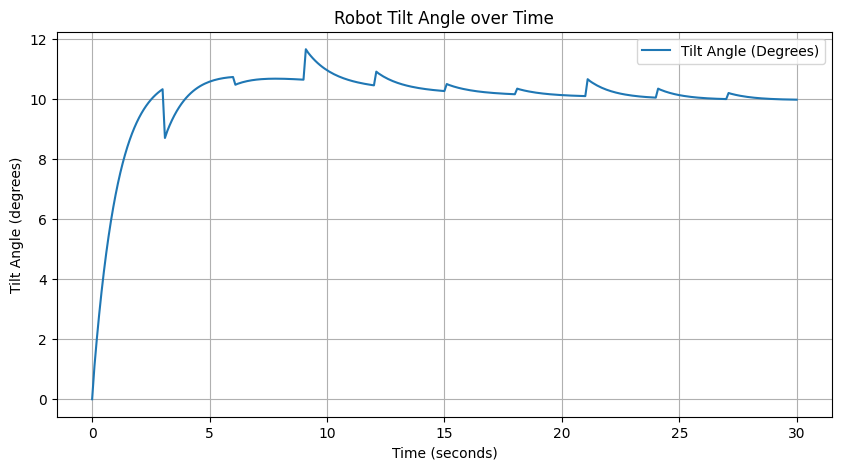

In [23]:
sim = Simulation(Controller(1.0, 0.1, 0.01), 1, 9.8, 0.1, 0.5, 0.2, 0.1, 0)
plot_angles(*sim.simulate(setpoint=10, totalTime=30))

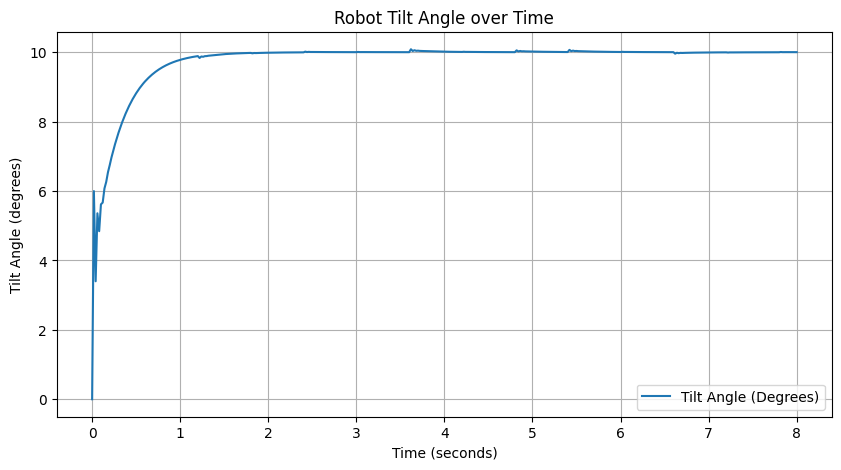

In [24]:
sim = Simulation(Controller(50, 0.1, 5), 9, 9.8, 0.2, 0.75, 0.5, 0.02, 0)
plot_angles(*sim.simulate(setpoint=10, totalTime=8))